In [6]:
versioninfo()

Julia Version 1.9.3
Commit bed2cd540a1 (2023-08-24 14:43 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 32 × Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, haswell)
  Threads: 2 on 32 virtual cores
Environment:
  JULIA_PKG_SERVER = https://mirrors.tuna.tsinghua.edu.cn/julia


In [9]:
# set the output format of gr backend to png. default is svg, which maldisplays in jupyter pages (after restart).
# StatsPlots has an identical gr() function.
@time using Plots;
#gr(fmt = "png")
@time gr(fmt = :png)

#@time using StatsPlots; 
#@time gr(fmt = :png)

  0.009889 seconds (9.93 k allocations: 616.186 KiB)
  0.000061 seconds (5 allocations: 576 bytes)


Plots.GRBackend()

In [10]:
using CSV
using Random
using StatsBase
using DataFrames
using Turing
using StatsPlots
using StatsFuns
using LaTeXStrings
#using StatisticalRethinking
using StatisticalRethinking: link
using StatisticalRethinkingPlots
using ParetoSmooth
using ParetoSmoothedImportanceSampling
using Logging

default(labels=false)
Logging.disable_logging(Logging.Warn);

# 8.1 Building an interaction

## Code 8.1 Load data

In [11]:
d = DataFrame(CSV.File("data/rugged.csv"))
dd = d[completecases(d, :rgdppc_2000),:]
dd[:,:log_gdp] = log.(dd.rgdppc_2000);
dd[:,:log_gdp_std] = dd.log_gdp / mean(dd.log_gdp)
dd[:,:rugged_std] = dd.rugged / maximum(dd.rugged);

In [47]:
dd

Row,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,lon,soil,desert,tropical,dist_coast,near_coast,gemstones,rgdppc_2000,rgdppc_1950_m,rgdppc_1975_m,rgdppc_2000_m,rgdppc_1950_2000_m,q_rule_law,cont_africa,cont_asia,cont_europe,cont_oceania,cont_north_america,cont_south_america,legor_gbr,legor_fra,legor_soc,legor_deu,legor_sca,colony_esp,colony_gbr,colony_fra,colony_prt,colony_oeu,africa_region_n,africa_region_s,africa_region_w,africa_region_e,africa_region_c,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent,log_gdp,log_gdp_std,rugged_std,cid
,String3,Int64,String,Float64,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Int64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Int64,Int64,Int64,Int64,Int64,Int64,Int64?,Int64?,Int64?,Int64?,Int64?,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64?,Float64?,Float64?,Float64?,Int64?,Float64?,Float64,Float64,Float64,Int64
1,AGO,24,Angola,0.858,0.714,2.274,0.228,4.906,124670.0,-12.299,17.551,26.676,0.425,44.346,0.428,13.1587,47756,1794.73,1051.82,1073.04,765.215,1106.76,-1.567,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,3.61e6,5.669,6.981,4.926,3.872,1223208,2.0,7.49261,0.879712,0.138342,1
2,ALB,8,Albania,3.427,1.597,10.451,1.006,62.133,2740.0,41.143,20.07,68.088,0.0,0.0,0.048,94.6919,0,3703.11,1001.34,2289.47,2741.42,1931.78,-0.82,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,missing,missing,missing,missing,200000,100.0,8.21693,0.964755,0.552564,2
3,ARE,784,United Arab Emirates,0.769,0.316,2.112,0.191,6.142,8360.0,23.913,54.331,0.0,77.28,0.0,0.065,75.7464,0,20604.5,15797.6,25465.0,17567.9,20120.0,0.913,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,missing,missing,missing,missing,19200,0.0,9.93326,1.16627,0.123992,2
4,ARG,32,Argentina,0.775,0.22,2.268,0.226,9.407,273669.0,-35.396,-65.17,35.678,0.0,0.0,0.352,13.0167,0,12173.7,4986.73,8122.5,8543.56,6926.81,0.033,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,missing,missing,missing,missing,276632,89.889,9.40703,1.10449,0.12496,2
5,ARM,51,Armenia,2.688,0.934,8.178,0.799,50.556,2820.0,40.294,44.938,30.148,0.0,0.0,0.348,0.0,0,2421.99,missing,missing,4565.03,missing,-0.453,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,missing,missing,missing,missing,105743,0.5,7.79234,0.914904,0.433409,2
6,ATG,28,Antigua and Barbuda,0.006,0.003,0.012,0.003,0.0,44.0,17.271,-61.8,100.0,0.0,100.0,0.001,100.0,0,10022.0,missing,missing,missing,missing,0.99,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,missing,missing,missing,missing,747,missing,9.21254,1.08165,0.00096743,2
7,AUS,36,Australia,0.143,0.183,0.405,0.045,0.685,768230.0,-25.733,134.487,14.248,10.889,14.68,0.336,20.9399,264154,25417.4,7411.58,13169.8,21605.3,13184.2,1.773,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,missing,missing,missing,missing,200000,89.954,10.1432,1.19092,0.0230571,2
8,AUT,40,Austria,3.513,1.152,11.095,1.008,54.307,8245.0,47.589,14.14,55.098,0.0,0.0,0.242,2.25634,0,28987.8,3706.07,11646.4,20691.4,11601.7,1.853,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,missing,missing,missing,missing,1250000,98.4,10.2746,1.20635,0.56643,2
9,AZE,31,Azerbaijan,1.672,0.534,5.08,0.49,27.713,8260.5,40.288,47.528,60.957,0.0,0.0,0.584,0.0,0,2570.94,missing,missing,2538.14,missing,-1.007,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,missing,missing,missing,missing,226250,4.0,7.85203,0.921911,0.26959,2


## Code 8.2 m8.1 with $\sigma$=1 for priors of a and b

In [12]:
r̄ = mean(dd.rugged_std)

@model function model_m8_1(rugged_std, log_gdp_std)
    σ ~ Exponential()
    a ~ Normal(1, 1)
    b ~ Normal(0, 1)
    μ = @. a + b * (rugged_std - r̄)
    log_gdp_std ~ MvNormal(μ, σ)
end

model_m8_1 (generic function with 2 methods)

## Code 8.3 Fit m8.1

In [13]:
m8_1_p = sample(model_m8_1(dd.rugged_std, dd.log_gdp_std), Prior(), 1000)
m8_1_p_df = DataFrame(m8_1_p);

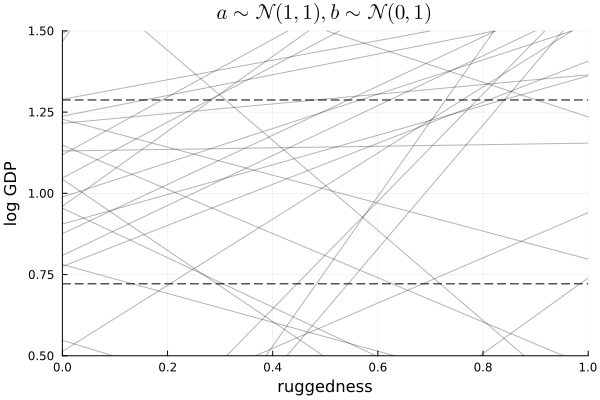

In [14]:
rugged_seq = range(-0.1, 1.1; length=30)
μ = link(m8_1_p_df, (r, x) -> r.a + r.b*(x - r̄), rugged_seq)
μ = hcat(μ...)

p = plot(
    xlim=(0, 1),
    ylim=(0.5, 1.5),
    title=L"a \sim \mathcal{N}(1,1), b \sim \mathcal{N}(0, 1)",
    xlab="ruggedness", ylab="log GDP",
)
hline!(collect(extrema(dd.log_gdp_std)); c=:black, s=:dash)
for μ₀ ∈ first(eachrow(μ), 50)
    plot!(rugged_seq, μ₀; c=:black, alpha=0.3)
end
p

## Code 8.4 Percentage of beta>0.6

In [15]:
mean(abs.(m8_1_p_df.b) .> 0.6)

0.554

## Code 8.5 m8.1a with $\sigma$=0.1 or 0.3 for priors of a and b 

In [16]:
r̄ = mean(dd.rugged_std)

@model function model_m8_1a(rugged_std, log_gdp_std)
    σ ~ Exponential()
    a ~ Normal(1, 0.1)
    b ~ Normal(0, 0.3)
    μ = @. a + b * (rugged_std - r̄)
    log_gdp_std ~ MvNormal(μ, σ)
end

m8_1 = sample(model_m8_1a(dd.rugged_std, dd.log_gdp_std), NUTS(), 1000)
m8_1_df = DataFrame(m8_1);

## Code 8.6 Posterior estimates of parameters in m8.1a

In [17]:
precis(m8_1_df)

┌───────┬──────────────────────────────────────────────────────┐
│ param │   mean     std     5.5%     50%   94.5%    histogram │
├───────┼──────────────────────────────────────────────────────┤
│     a │ 1.0002  0.0107   0.9829  1.0001  1.0173    ▁▁▄██▄▁▁▁ │
│     b │ 0.0027  0.0546  -0.0872  0.0042  0.0881     ▁▁▄██▄▁▁ │
│     σ │ 0.1381  0.0076    0.126  0.1379  0.1507  ▁▁▄▇█▇▄▂▁▁▁ │
└───────┴──────────────────────────────────────────────────────┘



- log_GDP ~ Norm($\mu$, $\sigma$)
- $\mu$ ~ 1.0 + 0.0027 * (rugged_std - avg_rugged_std)
- $\sigma = 0.1381$ 

In [20]:
parentmodule(precis)

StatisticalRethinking

## Code 8.7 categorical variable for continent

In [18]:
dd[:,:cid] = @. ifelse(dd.cont_africa == 1, 1, 2);

## Code 8.8 m8.2 Different intercept for different continent

In [21]:
@model function model_m8_2(rugged_std, cid,  log_gdp_std)
    σ ~ Exponential()
    a ~ MvNormal([1, 1], 0.1)
    b ~ Normal(0, 0.3)
    μ = @. a[cid] + b * (rugged_std - r̄)
    log_gdp_std ~ MvNormal(μ, σ)
end

m8_2 = sample(model_m8_2(dd.rugged_std, dd.cid,  dd.log_gdp_std), NUTS(), 1000)
m8_2_df = DataFrame(m8_2);

## Code 8.9 Compare m8.1a and m8.2

In [22]:
# Compute log likelihoods for both models
fun = (r, (x,y)) -> normlogpdf(r.a + r.b * (x - r̄), r.σ, y)
m8_1_ll = link(m8_1_df, fun, zip(dd.rugged_std, dd.log_gdp_std))
m8_1_ll = hcat(m8_1_ll...)

# need DF with a as a vector of both a[1] and a[2]
df = DataFrame(m8_2_df)
df[!,:a] = collect.(zip(m8_2_df.:"a[1]", m8_2_df.:"a[2]"))

fun = (r, (x,c,y)) -> normlogpdf(r.a[c] + r.b * (x - r̄), r.σ, y)
m8_2_ll = link(df, fun, zip(dd.rugged_std, dd.cid, dd.log_gdp_std))
m8_2_ll = hcat(m8_2_ll...);

compare([m8_1_ll, m8_2_ll], :waic, mnames=["m8.1", "m8.2"])

Row,models,WAIC,lppd,SE,dWAIC,dSE,pWAIC,weight
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,m8.2,-252.9,-260.68,14.84,0.0,0.0,3.89,1.0
2,m8.1,-188.9,-194.01,12.98,64.0,14.72,2.56,0.0


## Code 8.10 Posterior estimates of m8.2

In [23]:
precis(m8_2_df)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%       histogram │
├───────┼───────────────────────────────────────────────────────────┤
│  a[1] │  0.8807  0.0151   0.8571   0.8806  0.9045     ▁▁▂▅██▆▃▁▁▁ │
│  a[2] │  1.0493    0.01   1.0335   1.0489  1.0657  ▁▁▁▃▅▇█▇▇▄▂▁▁▁ │
│     b │ -0.0469  0.0459  -0.1181  -0.0488  0.0282         ▁▃██▄▁▁ │
│     σ │  0.1139  0.0061   0.1048   0.1136  0.1233      ▁▂▆█▇▃▁▁▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


## Code 8.11 $\Delta_{Intercept}$ between African and non-African

In [24]:
PI(map(r -> r[1] - r[2], df.a))

2-element Vector{Float64}:
 -0.1960452455892236
 -0.13904128391740345

## Code 8.12 Plot 

In [25]:
rugged_seq = range(-0.1, 1.1, length=30)
africa     = link(df, (r, x) -> r.a[1] + r.b*(x-r̄), rugged_seq)
africa     = hcat(africa...)'
not_africa = link(df, (r, x) -> r.a[2] + r.b*(x-r̄), rugged_seq)
not_africa = hcat(not_africa...)'

μₐ = mean.(eachrow(africa))
μₙ = mean.(eachrow(not_africa))
PIₐ = PI.(eachrow(africa))
PIₐ = vcat(PIₐ'...)
PIₙ = PI.(eachrow(not_africa))
PIₙ = vcat(PIₙ'...);

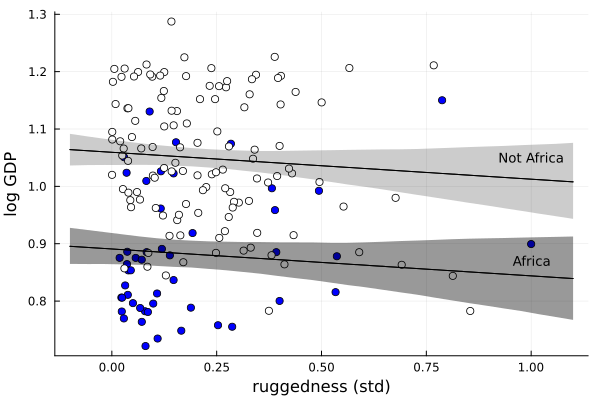

In [26]:
p = plot(xlab="ruggedness (std)", ylab="log GDP")
scatter!(dd.rugged_std[dd.cid.==1], dd.log_gdp_std[dd.cid.==1], c=:blue)
scatter!(dd.rugged_std[dd.cid.==2], dd.log_gdp_std[dd.cid.==2], c=:white)

plot!(rugged_seq, [μₐ, μₐ], c=:black, fillrange=PIₐ, fillalpha=0.4)
plot!(rugged_seq, [μₙ, μₙ], c=:black, fillrange=PIₙ, fillalpha=0.2)
annotate!([
    (1, 0.87, ("Africa", 9)),
    (1, 1.05, ("Not Africa", 9))
])

## Code 8.13 m8.3: Different intercept and different slope based on different continent

In [27]:
@model function model_m8_3(rugged_std, cid,  log_gdp_std)
    σ ~ Exponential()
    a ~ MvNormal([1, 1], 0.1)
    b ~ MvNormal([0, 0], 0.3)
    μ = @. a[cid] + b[cid] * (rugged_std - r̄)
    log_gdp_std ~ MvNormal(μ, σ)
end

m8_3 = sample(model_m8_3(dd.rugged_std, dd.cid,  dd.log_gdp_std), NUTS(), 1000)
m8_3_df = DataFrame(m8_3);

## Code 8.14 Posterior estimates of m8.3

In [28]:
precis(m8_3_df)

┌───────┬────────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%       histogram │
├───────┼────────────────────────────────────────────────────────────┤
│  a[1] │  0.8868  0.0163   0.8611    0.887    0.913    ▁▁▂▄▆██▄▃▁▁▁ │
│  a[2] │  1.0502  0.0098    1.035   1.0499    1.066  ▁▁▁▂▄▆██▆▄▃▁▁▁ │
│  b[1] │  0.1293  0.0753   0.0088   0.1306   0.2452    ▁▁▁▂▃▆█▇▄▂▁▁ │
│  b[2] │ -0.1421  0.0536  -0.2295  -0.1408  -0.0577        ▁▁▃▇█▄▁▁ │
│     σ │  0.1117  0.0064   0.1019   0.1115   0.1225     ▁▁▃██▅▃▁▁▁▁ │
└───────┴────────────────────────────────────────────────────────────┘


## Code 8.15 Compare m8.1, m8.2, m8.3

In [29]:
df3 = DataFrame(m8_3_df)
df3[!,:a] = collect.(zip(m8_3_df.:"a[1]", m8_3_df.:"a[2]"))
df3[!,:b] = collect.(zip(m8_3_df.:"b[1]", m8_3_df.:"b[2]"))

fun = (r, (x,c,y)) -> normlogpdf(r.a[c] + r.b[c] * (x - r̄), r.σ, y)
m8_3_ll = link(df3, fun, zip(dd.rugged_std, dd.cid, dd.log_gdp_std))
m8_3_ll = hcat(m8_3_ll...);

compare([m8_1_ll, m8_2_ll, m8_3_ll], :psis, mnames=["m8.1", "m8.2", "m8.3"])

Row,models,PSIS,lppd,SE,dPSIS,dSE,pPSIS,weight
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,m8.3,-260.1,-269.09,14.52,0.0,0.0,4.83,0.97
2,m8.2,-253.4,-260.68,14.78,6.7,6.34,3.89,0.03
3,m8.1,-189.2,-194.01,12.96,70.9,14.81,2.56,0.0


In [30]:
parentmodule(compare)

StatisticalRethinking

## Code 8.16 Plot Pareto's k

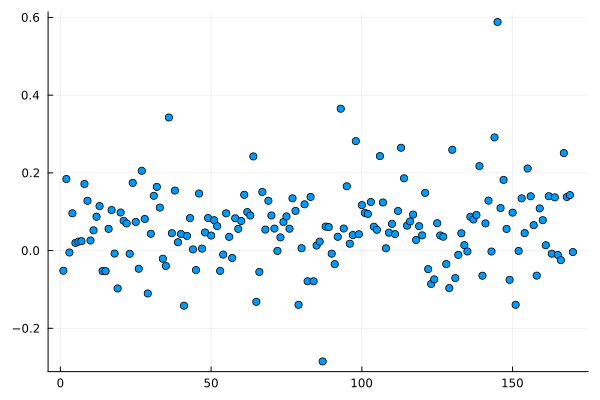

In [31]:
t = m8_3_ll'
m8_3_t = collect(reshape(t, size(t)..., 1))
PSIS_m8_3 = psis_loo(m8_3_t)
scatter(PSIS_m8_3.pointwise(:pareto_k))

## Code 8.17 Plot

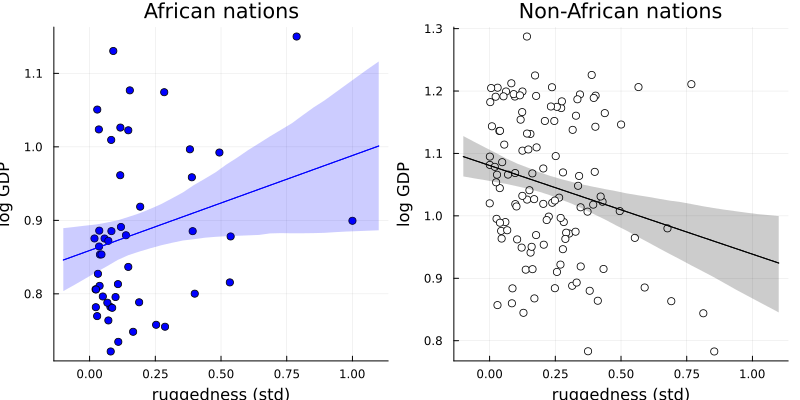

In [32]:
# build data
africa     = link(df3, (r, x) -> r.a[1] + r.b[1]*(x-r̄), rugged_seq)
africa     = hcat(africa...)'
not_africa = link(df3, (r, x) -> r.a[2] + r.b[2]*(x-r̄), rugged_seq)
not_africa = hcat(not_africa...)'

μₐ = mean.(eachrow(africa))
μₙ = mean.(eachrow(not_africa))
PIₐ = PI.(eachrow(africa))
PIₐ = vcat(PIₐ'...)
PIₙ = PI.(eachrow(not_africa))
PIₙ = vcat(PIₙ'...);

# plot Africa, cid=1
p1 = plot(xlab="ruggedness (std)", ylab="log GDP", title="African nations")
scatter!(dd.rugged_std[dd.cid.==1], dd.log_gdp_std[dd.cid.==1], c=:blue)
plot!(rugged_seq, [μₐ, μₐ], c=:blue, fillrange=PIₐ, fillalpha=0.2)

# plot non Africa, cid=2
p2 = plot(xlab="ruggedness (std)", ylab="log GDP", title="Non-African nations")
scatter!(dd.rugged_std[dd.cid.==2], dd.log_gdp_std[dd.cid.==2], c=:white)
plot!(rugged_seq, [μₙ, μₙ], c=:black, fillrange=PIₙ, fillalpha=0.2)

plot(p1, p2, size=(800, 400))

# 8.2 Symmetry of interations

## Code 8.18 Plot $\Delta_{GDP}$ between African and non-African at different ruggedness

In [33]:
rugged_seq = range(-0.2, 1.2, length=30)
μA = link(df3, (r, x) -> r.a[1] + r.b[1]*(x-r̄), rugged_seq)
μA = vcat(μA'...)
μN = link(df3, (r, x) -> r.a[2] + r.b[2]*(x-r̄), rugged_seq)
μN = vcat(μN'...)
delta = μA .- μN;

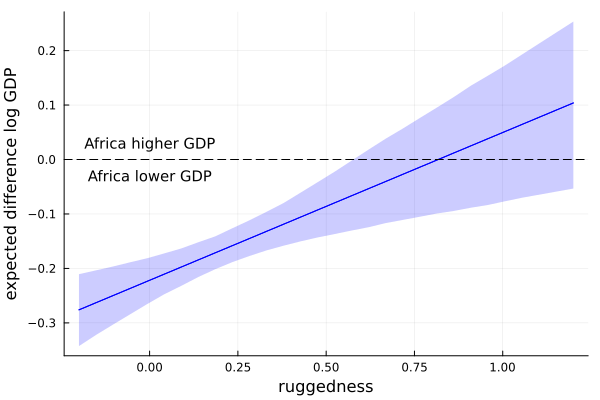

In [35]:
μ = mean.(eachrow(delta))
PI_v = PI.(eachrow(delta))
PI_v = vcat(PI_v'...)

plot(xlab="ruggedness", ylab="expected difference log GDP",)
plot!(rugged_seq, [μ, μ], c=:blue, fillrange=PI_v, fillalpha=0.2)
hline!([0.0], s=:dash, c=:black)
annotate!([
    (0.0, 0.03, ("Africa higher GDP", 10)),
    (0.0, -0.03, ("Africa lower GDP", 10)),
])

# 8.3 Continuous interaction

## Code 8.19 Load data

In [36]:
d = DataFrame(CSV.File("data/tulips.csv"))
describe(d)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,bed,,a,,c,0,String1
2,water,2.0,1,2.0,3,0,Int64
3,shade,2.0,1,2.0,3,0,Int64
4,blooms,128.994,0.0,111.04,361.66,0,Float64


In [48]:
d

Row,bed,water,shade,blooms,blooms_std,water_cent,shade_cent
,String1,Int64,Int64,Float64,Float64,Float64,Float64
1,a,1,1,0.0,0.0,-1.0,-1.0
2,a,1,2,0.0,0.0,-1.0,0.0
3,a,1,3,111.04,0.307029,-1.0,1.0
4,a,2,1,183.47,0.5073,0.0,-1.0
5,a,2,2,59.16,0.163579,0.0,0.0
6,a,2,3,76.75,0.212216,0.0,1.0
7,a,3,1,224.97,0.622048,1.0,-1.0
8,a,3,2,83.77,0.231626,1.0,0.0
9,a,3,3,134.95,0.373141,1.0,1.0


## Code 8.20 Standardize the data

In [37]:
d.blooms_std = d.blooms / maximum(d.blooms)
d.water_cent = d.water .- mean(d.water)
d.shade_cent = d.shade .- mean(d.shade);

## Code 8.21 Fraction of a outside the reasonable range

In [38]:
Random.seed!(1)
a = rand(Normal(0.5, 1), 10^4)
sum(@. (a < 0) | (a > 1))/length(a)

0.6242

## Code 8.22

In [39]:
Random.seed!(1)
a = rand(Normal(0.5, 0.25), 10^4)
sum(@. (a < 0) | (a > 1))/length(a)

0.0496

## Code 8.23 m8.4

In [40]:
@model function m8_4(water_cent, shade_cent, blooms_std)
    a ~ Normal(0.5, 0.25)
    bw ~ Normal(0, 0.25)
    bs ~ Normal(0, 0.25)
    μ = @. a + bw*water_cent + bs*shade_cent
    σ ~ Exponential(1)
    blooms_std ~ MvNormal(μ, σ)
end

m8_4_c = sample(m8_4(d.water_cent, d.shade_cent, d.blooms_std), NUTS(), 1000)
m8_4_df = DataFrame(m8_4_c)
precis(m8_4_df)

┌───────┬────────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%       histogram │
├───────┼────────────────────────────────────────────────────────────┤
│     a │  0.3576  0.0363   0.2998   0.3569   0.4167   ▁▁▁▂▄▅██▅▃▂▁▁ │
│    bs │ -0.1105  0.0418  -0.1786  -0.1101  -0.0441  ▁▁▂▃▅▇█▇▅▃▂▁▁▁ │
│    bw │  0.2038  0.0423   0.1379    0.203   0.2712         ▁▂██▃▁▁ │
│     σ │  0.1776  0.0281   0.1421   0.1732   0.2285     ▁▂▇█▆▄▂▁▁▁▁ │
└───────┴────────────────────────────────────────────────────────────┘


## Code 8.24 m8.5 with interactions

In [41]:
@model function m8_5(water_cent, shade_cent, blooms_std)
    a ~ Normal(0.5, 0.25)
    bw ~ Normal(0, 0.25)
    bs ~ Normal(0, 0.25)
    bws ~ Normal(0, 0.25)
    μ = @. a + bw*water_cent + bs*shade_cent + bws*water_cent*shade_cent
    σ ~ Exponential(1)
    blooms_std ~ MvNormal(μ, σ)
end

m8_5_c = sample(m8_5(d.water_cent, d.shade_cent, d.blooms_std), NUTS(), 1000)
m8_5_df = DataFrame(m8_5_c)
precis(m8_5_df)

┌───────┬────────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%       histogram │
├───────┼────────────────────────────────────────────────────────────┤
│     a │  0.3585  0.0273   0.3172    0.358    0.404     ▁▁▂▅██▄▂▁▁▁ │
│    bs │ -0.1137  0.0323  -0.1658   -0.113  -0.0615   ▁▁▁▁▂▄▇█▆▃▂▁▁ │
│    bw │  0.2043  0.0343   0.1511   0.2056   0.2567  ▁▁▁▁▂▅▇█▆▃▂▁▁▁ │
│   bws │ -0.1407  0.0423  -0.2061  -0.1409  -0.0735         ▁▂██▃▁▁ │
│     σ │  0.1424  0.0222   0.1117     0.14   0.1802       ▁▄█▇▄▁▁▁▁ │
└───────┴────────────────────────────────────────────────────────────┘


## Code 8.25 Triptych: Bloom vs Water at different shades

### m8.4 (without interaction)

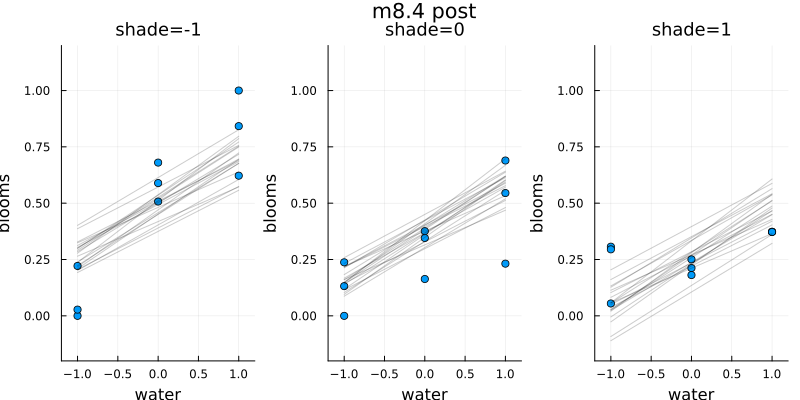

In [42]:
plts = []

for shade ∈ -1:1
    idx = findall(==(shade), d.shade_cent)
    p = plot(xlims=(-1.2,1.2), ylims=(-.2,1.2), xlab="water", ylab="blooms", 
             title="shade=$shade", titlefontsize=12)
    scatter!(d.water_cent[idx], d.blooms_std[idx])
    water_seq = -1:1
    mu = link(m8_4_df, (r, water) -> r.a + r.bw * water + r.bs * shade, water_seq)
    mu = hcat(mu...);
    for μ ∈ first(eachrow(mu), 20)
        plot!(water_seq, μ, c=:black, alpha=0.2)
    end
    push!(plts, p)
end
plot(plts..., layout=(1, 3), size=(800, 400), plot_title="m8.4 post", plot_titlefontsize=14)

### m8.5 (with interaction)

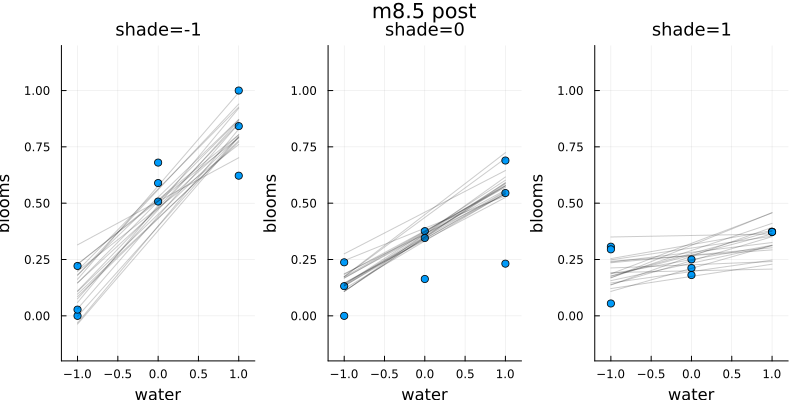

In [43]:
plts = []

for shade ∈ -1:1
    idx = findall(==(shade), d.shade_cent)
    p = plot(xlims=(-1.2,1.2), ylims=(-.2,1.2), xlab="water", ylab="blooms", 
             title="shade=$shade", titlefontsize=12)
    scatter!(d.water_cent[idx], d.blooms_std[idx])
    water_seq = -1:1
    mu = link(m8_5_df, (r, water) -> r.a + r.bw*water + r.bs*shade + r.bws*water*shade, water_seq)
    mu = hcat(mu...);
    for μ ∈ first(eachrow(mu), 20)
        plot!(water_seq, μ, c=:black, alpha=0.2)
    end
    push!(plts, p)
end
plot(plts..., layout=(1, 3), size=(800, 400), plot_title="m8.5 post", plot_titlefontsize=14)

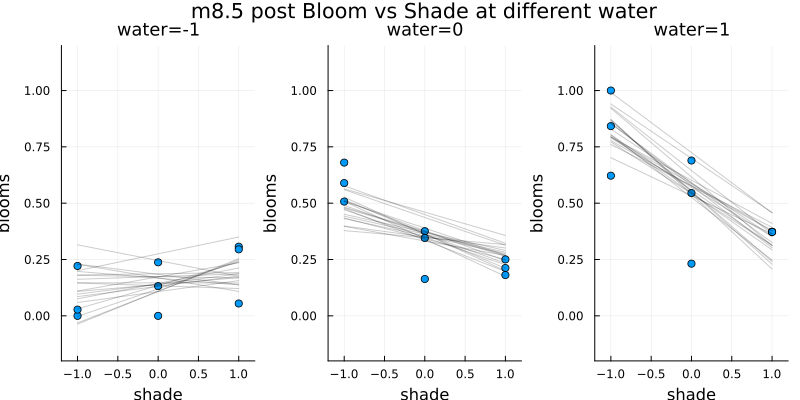

In [44]:
plts = []

for water ∈ -1:1
    idx = findall(==(water), d.water_cent)
    p = plot(xlims=(-1.2,1.2), ylims=(-.2,1.2), xlab="shade", ylab="blooms", 
             title="water=$water", titlefontsize=12)
    scatter!(d.shade_cent[idx], d.blooms_std[idx])
    shade_seq = -1:1
    mu = link(m8_5_df, (r, shade) -> r.a + r.bw*water + r.bs*shade + r.bws*water*shade, shade_seq)
    mu = hcat(mu...);
    for μ ∈ first(eachrow(mu), 20)
        plot!(shade_seq, μ, c=:black, alpha=0.2)
    end
    push!(plts, p)
end
plot(plts..., layout=(1, 3), size=(800, 400), plot_title="m8.5 post Bloom vs Shade at different water", plot_titlefontsize=14)

## Code 8.26 Same Triptych, but for the prior predictive simulations

In [45]:
Random.seed!(7)
m8_5p_c = sample(m8_5(d.water_cent, d.shade_cent, d.blooms_std), Prior(), 1000)
m8_5p_df = DataFrame(m8_5p_c);

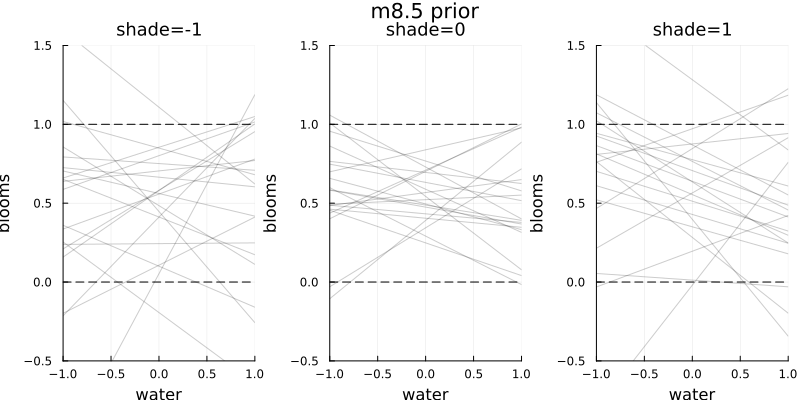

In [46]:
plts = []

for shade ∈ -1:1
    p = plot(xlims=(-1, 1), ylims=(-0.5, 1.5), xlab="water", ylab="blooms", 
             title="shade=$shade", titlefontsize=12)
    water_seq = -1:1
    mu = link(m8_5p_df, (r, water) -> r.a + r.bw*water + r.bs*shade + r.bws*water*shade, water_seq)
    mu = hcat(mu...);
    for μ ∈ first(eachrow(mu), 20)
        plot!(water_seq, μ, c=:black, alpha=0.2)
    end
    hline!([0.0, 1.0], s=:dash, c=:black)
    push!(plts, p)
end
plot(plts..., layout=(1, 3), size=(800, 400), plot_title="m8.5 prior", plot_titlefontsize=14)